In [1]:
from pydantic import BaseModel, Field

# Pydantic을 사용한 State 정의
class AgentState(BaseModel):
    user_message: str = Field(default="", description="사용자 입력 작업")
    task_details: str = Field(default="", description="작업 상세 정보")
    response: str = Field(default="", description="응답 결과")

In [2]:
# 노드 함수 정의
def get_llm_response_node(state: AgentState, llm):
    """LLM과 상호작용하여 응답을 생성하거나, 추가 정보를 요청하는 노드"""
    details = state.task_details

    if details:
        print(f"\n상세 정보를 바탕으로 작업 실행: '{details}'")
        prompt = f"다음 요청에 따라 보고서를 작성해주세요: {details}"
    else:
        task = state.user_message
        print(f"\n작업 실행: '{task}' 작업을 수행합니다...")
        # LLM에게 상세 정보를 묻는 질문을 하도록 유도하고, 반드시 '?'로 끝내도록 지시
        prompt = f"'{task}' 작업을 수행하려고 합니다. 어떤 종류의 보고서가 필요한지, 구체적인 주제는 무엇인지 질문해주세요. 추가 정보가 필요하면, 반드시 응답의 마지막을 물음표('?')로 끝내주세요."

    response = llm.invoke(prompt).content

    print("--- LLM 응답 ---")
    print(response)
    print("--------------------")

    return {"response": response, "task_details": ""}

In [3]:

# 사람의 입력을 받는 노드
def get_task_details_node(state: AgentState) -> AgentState:
    """LLM의 질문에 대한 사용자 답변을 입력받는 노드"""
    print("\nLLM의 질문에 답변해주세요.")
    user_input = input("답변: ")
    return {"task_details": user_input}

In [4]:

from typing import Literal

# 조건부 분기 노드
def check_llm_response(state: AgentState) -> Literal["get_details", "end"]:
    """LLM의 응답이 질문인지 확인하여 다음 단계를 결정합니다."""
    print("LLM 응답 분석 중...")
    if state.response.strip().endswith("?"): # 문자열의 끝이 "?"이면 true
        print("LLM이 추가 정보를 요청했습니다. 사용자 입력을 받습니다.")
        return "get_details"
    print("최종 보고서가 생성되었습니다. 워크플로우를 종료합니다.")
    return "end"

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [6]:
def get_llm_response_with_llm(state):
    return get_llm_response_node(state, model)

In [7]:

from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)
graph_builder.add_node("get_llm_response", get_llm_response_with_llm)
graph_builder.add_node("get_details", get_task_details_node)

graph_builder.add_edge(START, "get_llm_response")
graph_builder.add_conditional_edges(
    "get_llm_response",
    check_llm_response,
    {
        "get_details": "get_details",
        "end": END,
    },
)
graph_builder.add_edge("get_details", "get_llm_response")

In [8]:
graph = graph_builder.compile()

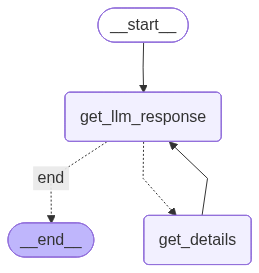

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
final_state = graph.invoke(AgentState(user_message="블로그 글 작성"))


작업 실행: '블로그 글 작성' 작업을 수행합니다...
--- LLM 응답 ---
블로그 글 작성을 도와드리겠습니다!

어떤 종류의 블로그 글을 작성하고 싶으신가요? (예: 정보성 글, 제품 리뷰, 여행 후기, 특정 주제에 대한 가이드, 개인적인 경험 공유 등) 그리고 구체적인 주제는 무엇인가요?
--------------------
LLM 응답 분석 중...
LLM이 추가 정보를 요청했습니다. 사용자 입력을 받습니다.

LLM의 질문에 답변해주세요.

상세 정보를 바탕으로 작업 실행: '케이팝데몬헌터스가 왜 전 세계적으로 유행할까'
--- LLM 응답 ---
## 보고서: '케이팝 데몬 헌터스(K-Pop Demon Hunters)'의 전 세계적 흥행 요인 분석

### 1. 서론

'케이팝 데몬 헌터스(K-Pop Demon Hunters)'는 케이팝(K-Pop) 아이돌 문화와 다크 판타지 액션 장르를 독창적으로 결합한 콘텐츠로, 전 세계적으로 폭발적인 인기를 얻고 있습니다. 이 보고서는 '케이팝 데몬 헌터스'가 단순한 유행을 넘어 하나의 문화 현상으로 자리매김할 수 있었던 주요 요인들을 다각적으로 분석하고자 합니다.

### 2. 흥행 요인 분석

#### 2.1. 케이팝(K-Pop)의 강력한 팬덤 및 문화적 영향력

*   **글로벌 팬덤 기반:** 케이팝은 이미 전 세계적으로 강력하고 조직적인 팬덤을 구축하고 있습니다. '케이팝 데몬 헌터스'는 이 거대한 팬덤을 초기 유입층으로 활용하여 콘텐츠 확산에 매우 유리한 입지를 확보했습니다. 팬들은 자신이 사랑하는 케이팝 아이돌의 이미지를 투영하거나, 케이팝 문화의 요소가 담긴 새로운 콘텐츠에 즉각적으로 반응했습니다.
*   **시각적 매력과 퍼포먼스:** 케이팝은 화려한 비주얼, 정교한 안무, 독창적인 무대 연출 등 시각적 요소가 매우 중요합니다. '케이팝 데몬 헌터스'는 이러한 케이팝의 강점을 데몬 헌팅 액션에 접목하여, 아이돌 특유의 칼군무나 무대 매너가 전투 기술 또는 마법 발동으로 이어지는 등 역동적이